El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_337125/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "DEAD FoundationsDAO"
ORG_PLATFORM = "daohaus"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 21:00"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 17738 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 0 to 17737
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       17738 non-null  object        
 1   name           17738 non-null  object        
 2   id             17738 non-null  object        
 3   proposal       17738 non-null  category      
 4   deployment     17738 non-null  object        
 5   platform_vote  17738 non-null  object        
 6   voter          17738 non-null  category      
 7   date           17738 non-null  datetime64[ns]
 8   choice         17738 non-null  object        
 9   weight         17738 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5591 entries, 0 to 5590
Data columns (total 13 columns):
 #   Column               Non-Null C

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x0000000813b34008a225de08a6a61835508c71f9,3447c17e-1b31-5f05-afb7-bf4f7b93292a,2021-11-17 19:14:10,1
1,0x0000000813b34008a225de08a6a61835508c71f9,58a6ac3d-5b72-5db9-b3af-84118704d120,2021-11-17 19:14:02,1
2,0x0000000813b34008a225de08a6a61835508c71f9,d607ecf5-04f8-53b9-8518-33c2bb09e990,2021-11-17 19:15:20,1
3,0x001be549fa377710b9e59d57bbdf593ce1e379ca,94dc6060-d66d-52fe-9c5d-8c7e43979569,2021-11-03 21:24:45,1
4,0x001be549fa377710b9e59d57bbdf593ce1e379ca,470cf9e2-b994-5279-8096-87a475e28c44,2021-11-03 21:26:15,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          5591
mean      4 days 23:52:29.242532641
std      16 days 13:03:30.437498999
min                 2 days 00:01:05
25%                 2 days 00:22:50
50%                 2 days 06:41:28
75%                 3 days 01:04:09
max               310 days 04:48:20
dtype: object

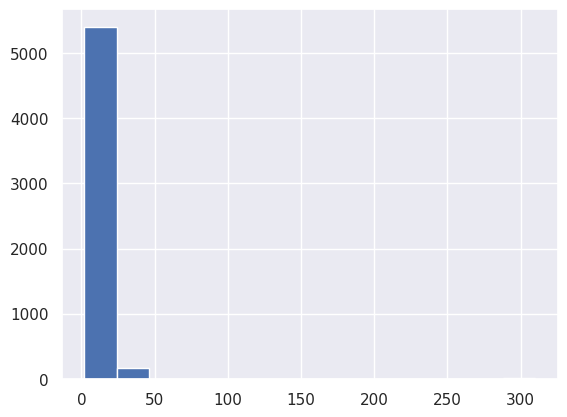

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

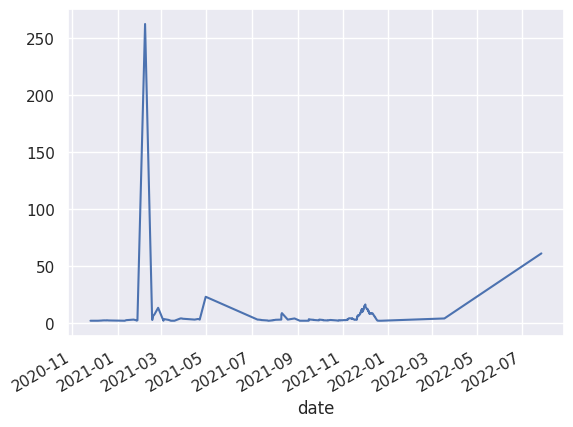

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Tuesday      1534
Saturday      965
Thursday      730
Friday        691
Monday        651
Sunday        598
Wednesday     422
Name: start, dtype: int64

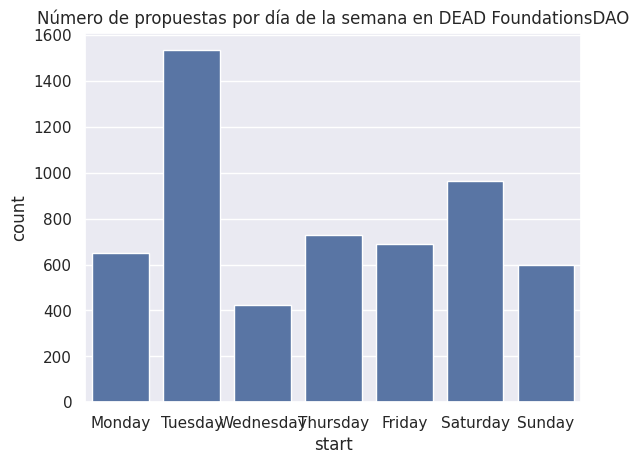

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Saturday     3089
Thursday     2724
Tuesday      2544
Monday       2415
Wednesday    2375
Friday       2322
Sunday       2269
Name: date, dtype: int64

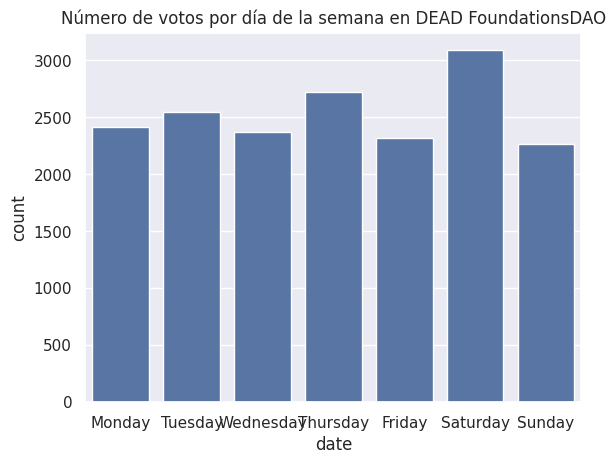

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

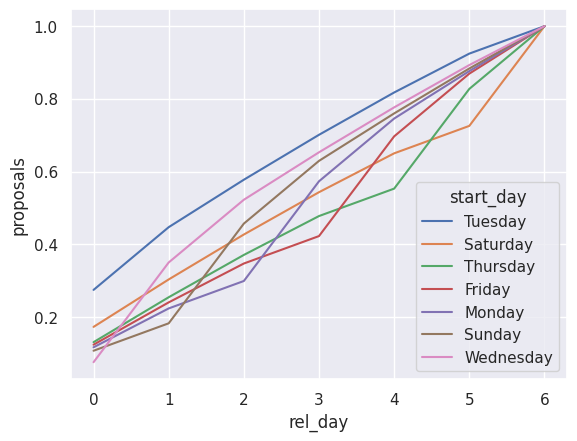

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

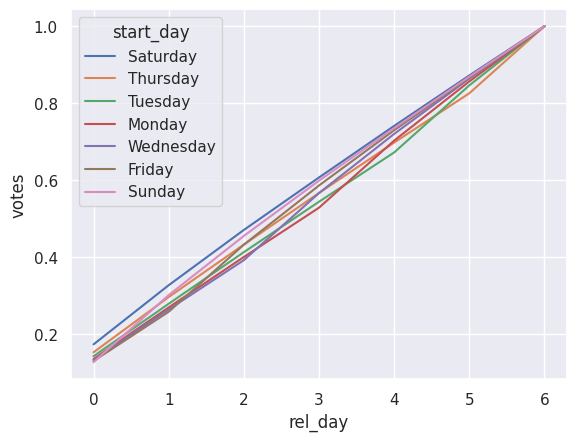

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

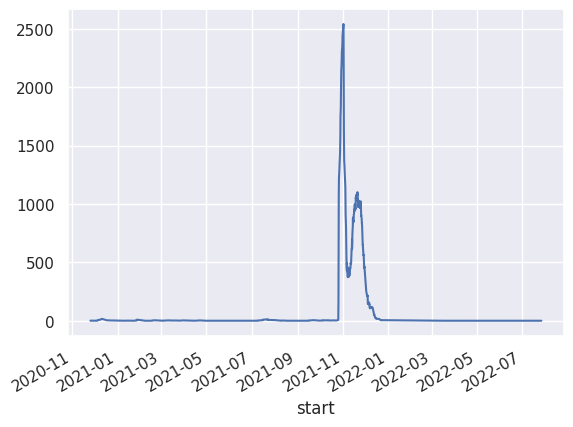

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                            W-SUN        W-MON        W-TUE  \
votes in open proposals (train) count    86.000000    86.000000    86.000000   
                                mean     62.569767    58.500000    52.360465   
                                std     304.761220   282.798234   220.968665   
                                min       0.000000     0.000000     0.000000   
                                50%       0.000000     0.000000     0.000000   
                                max    2566.000000  2331.000000  1387.000000   
users in open proposals (train) count    86.000000    86.000000    86.000000   
                                mean     18.220930    18.558140    15.593023   
                                std      87.269616    87.582244    64.666270   
                                min       0.000000     0.000000     0.000000   
                                50%       0.000000     0.000000     0.000000   
                                max     728.000000   716.000000   404.000000   
open proposals                  count    86.000000    86.000000    86.000000   
                                mean     42.709302    40.279070    41.127907   
                                std     122.660686   116.378455   118.680768   
                                min       0.000000     0.000000     0.000000   
                                50%       4.000000     4.000000     3.000000   
                                max     572.000000   611.000000   648.000000   
votes in test                   count    86.000000    86.000000    86.000000   
                                mean     10.697674     9.779070     9.162791   
                                std      43.086253    46.467547    33.811888   
                                min       0.000000     0.000000     0.000000   
                                50%       0.000000     0.000000     0.000000   
                                max     312.000000   383.000000   194.000000   
users in test                   count    86.000000    86.000000    86.000000   
                                mean      3.209302     2.662791     2.639535   
                                std      12.317483    10.186046    10.798598   
                                min       0.000000     0.000000     0.000000   
                                50%       0.000000     0.000000     0.000000   
                                max      70.000000    66.000000    75.000000   
vpp test                        count    79.000000    82.000000    80.000000   
                                mean      0.080799     0.090665     0.092238   
                                std       0.261532     0.246599     0.263762   
                                min       0.000000     0.000000     0.000000   
                                50%       0.000000     0.000000     0.000000   
                                max       1.666667     1.000000     1.666667   
vpu test                        count    12.000000    15.000000    15.000000   
                                mean      4.843373     3.964726     4.165782   
                                std       5.776683     4.952193     5.496516   
                                min       1.000000     1.000000     1.000000   
                                50%       2.474921     1.893939     1.760000   
                                max      19.000000    16.000000    20.000000   

f                                            W-WED        W-THU        W-SAT  
votes in open proposals (train) count    85.000000    86.000000    86.000000  
                                mean     58.470588    53.918605    55.848837  
                                std     231.659622   249.434854   259.988666  
                                min       0.000000     0.000000     0.000000  
                                50%       0.000000     0.000000     0.000000  
                                max    1199.000000  2050.000000  2158.000000  
users 

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_337125/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),5381.000000,5031.000000,4503.000000,4970.000000,4637.000000,4803.000000
users in open proposals (train),1567.000000,1596.000000,1341.000000,1265.000000,994.000000,1352.000000
open proposals,3673.000000,3464.000000,3537.000000,4455.000000,4015.000000,3517.000000
votes in test,920.000000,841.000000,788.000000,944.000000,997.000000,788.000000
users in test,276.000000,229.000000,227.000000,210.000000,219.000000,342.000000
vpp test,6.383101,7.434522,7.379075,6.164197,7.892369,12.001139
vpu test,58.120476,59.470887,62.486728,83.983714,115.679459,59.282944


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-01-12 20:26:45)  =====
Currently open proposals: 1
Train votes in open proposals:   1
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-03-14 02:17:55)  =====
Currently open proposals: 2
Train votes in open proposals:   1
Test votes in open proposals:    0

===== Training on fold 2 (t: 2021-04-22 00:50:50)  =====
Currently open proposals: 4
Train votes in open proposals:   3
Test votes in open proposals:    0

===== Training on fold 3 (t: 2021-05-16 10:10:35)  =====
Currently open proposals: 2
Train votes in open proposals:   1
Test votes in open proposals:    0

===== Training on fold 4 (t: 2021-08-18 18:06:25)  =====
Currently open proposals: 4
Train votes in open proposals:   6
Test votes in open proposals:    0

===== Training on fold 5 (t: 2021-10-19 18:07:05)  =====
Currently open proposals: 3
Train votes in open proposals:   6
Test votes in open proposals:    4



===== Training on fold 6 (t: 2021-12-17 12:40:00)  =====
Currently open proposals: 297
Train votes in open proposals: 106
Test votes in open proposals:  183



===== Training on fold 7 (t: 2021-12-26 11:40:35)  =====
Currently open proposals: 15
Train votes in open proposals:   2
Test votes in open proposals:    0

===== Training on fold 8 (t: 2022-03-17 21:46:45)  =====
Currently open proposals: 15
Train votes in open proposals:   1
Test votes in open proposals:    0



===== Training on fold 9 (t: 2022-03-17 21:46:45)  =====
Currently open proposals: 15
Train votes in open proposals:   1
Test votes in open proposals:   14


In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.180000,0.165000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345768,0.339975
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150000,0.075000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


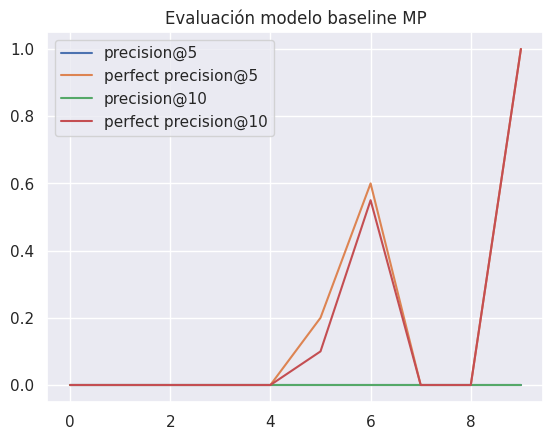

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.180000,0.300000,0.187088,0.187088,0.165000,0.300000,0.224176,0.224176,0.153333,0.300000,0.254121,0.254121
std,0.345768,0.483046,0.340173,0.340173,0.339975,0.483046,0.377989,0.377989,0.320570,0.483046,0.427802,0.427802
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.150000,0.750000,0.267857,0.267857,0.075000,0.750000,0.395604,0.395604,0.050000,0.750000,0.405907,0.405907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000


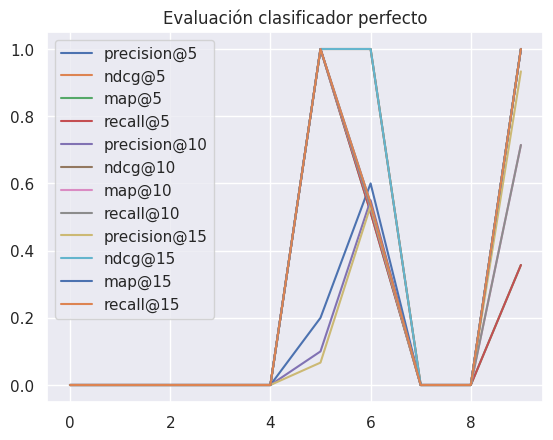

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/86 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 3
Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 6
Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 10
Warning, empty test fold 11


Warning, empty test fold 12
Warning, empty test fold 14
Warning, empty test fold 16


Warning, empty test fold 18
Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 22


Warning, empty test fold 23
Warning, empty test fold 24
Warning, empty test fold 25
Warning, empty test fold 26
Warning, empty test fold 27
Warning, empty test fold 28


Warning, empty test fold 29
Warning, empty test fold 30
Warning, empty test fold 31
Warning, empty test fold 32
Warning, empty test fold 33
Warning, empty test fold 34


Warning, empty test fold 36
Warning, empty test fold 37
Warning, empty test fold 38
Warning, empty test fold 39
Warning, empty test fold 40
Warning, empty test fold 41


Warning, empty test fold 42
Warning, empty test fold 43
Warning, empty test fold 44
Warning, empty test fold 45
Warning, empty test fold 46


Warning, empty test fold 57
Warning, empty test fold 58


Warning, empty test fold 59
Warning, empty test fold 60


Warning, empty test fold 61
Warning, empty test fold 62


Warning, empty test fold 63
Warning, empty test fold 64


Warning, empty test fold 65
Warning, empty test fold 66


Warning, empty test fold 67
Warning, empty test fold 68


Warning, empty test fold 69
Warning, empty test fold 70


Warning, empty test fold 71
Warning, empty test fold 72


Warning, empty test fold 73
Warning, empty test fold 74


Warning, empty test fold 75
Warning, empty test fold 76


Warning, empty test fold 77
Warning, empty test fold 78


Warning, empty test fold 79
Warning, empty test fold 80


Warning, empty test fold 81


Warning, empty test fold 83
Warning, empty test fold 84


Warning, empty test fold 85


In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2020-11-25 14:31:40 2022-07-26 17:09:25
t0: 2020-11-26 00:00:00
t1: 2020-12-03 00:00:00
t-2: 2022-07-07 00:00:00
t-1: 2022-07-14 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 86,
 'precision@5': 86,
 'ndcg@5': 86,
 'map@5': 86,
 'recall@5': 86,
 'precision@10': 86,
 'ndcg@10': 86,
 'map@10': 86,
 'recall@10': 86,
 'precision@15': 86,
 'ndcg@15': 86,
 'map@15': 86,
 'recall@15': 86}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2020-11-25 13:05:15')

Timestamp('2020-11-25 14:31:40')

,userID,itemID,timestamp,rating
1376,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,9b0951e8-192b-5b68-8e1a-1b392e5b704f,2020-11-25 14:31:40,1
1377,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,9903573c-d495-5c45-8209-c16ac4527667,2020-11-25 14:34:40,1
12696,0xa3564677fc4907a15c9a7eae1dbc1ae9ac57b8e1,83846b14-c310-5c84-a229-f8f88747a417,2020-12-04 01:16:40,1
1381,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,83846b14-c310-5c84-a229-f8f88747a417,2020-12-04 01:41:40,1
12699,0xa3564677fc4907a15c9a7eae1dbc1ae9ac57b8e1,e5b05bac-ebea-5d63-b09c-6721cb6c3b65,2020-12-05 00:14:50,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,title,description,start,end
0,daohaus,DEAD FoundationsDAO,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8,9b0951e8-192b-5b68-8e1a-1b392e5b704f,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...,0xa3564677fc4907a15c9a7eae1dbc1ae9ac57b8e1,2020-11-25 13:05:15,1,Kerp,Hhhereerrerer we goooooo!,2020-11-25 13:05:15,2020-11-27 16:35:40
1,daohaus,DEAD FoundationsDAO,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8,9903573c-d495-5c45-8209-c16ac4527667,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...,0x15c6ac4cf1b5e49c44332fb0a1043ccab19db80a,2020-11-25 14:32:45,1,wxdai tribute,to enable token syncing,2020-11-25 14:32:45,2020-11-27 16:36:55
1403,daohaus,DEAD FoundationsDAO,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8,83846b14-c310-5c84-a229-f8f88747a417,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...,0xcbbd18d3ac27ab0fffd04bccd091b2802c92e0ca,2020-12-04 01:12:45,2,Nick Rishwain,Joining Foundations DAO,2020-12-04 01:12:45,2020-12-06 19:33:50
4772,daohaus,DEAD FoundationsDAO,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8,e5b05bac-ebea-5d63-b09c-6721cb6c3b65,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...,0x3caa37c9c1c7cbc2259bc4cb28d180afd87a736b,2020-12-05 00:05:45,2,New Member VG,New Member VG,2020-12-05 00:05:45,2020-12-07 15:23:20
4886,daohaus,DEAD FoundationsDAO,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8,9af30869-f1cb-526b-b9fb-26a0f4b939a3,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,0x1b975a9daf25e7b01e0a6c72d657ff74925327a8-pro...,0x09b69644e0e687132e6bce0902a2cb79c3395564,2020-12-05 00:53:15,1,TheLastTriarius,Gaswarlord,2020-12-05 00:53:15,2020-12-07 18:05:30


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,0.008543,0.028788,0.024328,0.036122,0.004472,0.028629,0.024394,0.036683,0.003190,0.028997,0.024552,0.038551,0.057018,0.037897,0.154850
std,0.039024,0.143872,0.130796,0.184512,0.019982,0.143524,0.130788,0.184440,0.013401,0.143325,0.130766,0.184758,0.156083,0.127323,0.354915
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


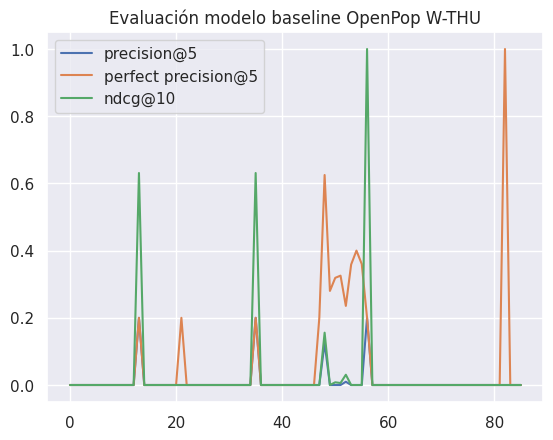

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.100000,0.071429
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.316228,0.225877
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.714286


,t,model,variable,value
0,2020-11-25 14:34:40,openpop,precision@5,0.000000
1,2020-11-25 14:34:40,openpop,precision@5,0.000000
2,2020-12-08 19:36:55,openpop,precision@5,0.000000
3,2020-12-14 23:33:20,openpop,precision@5,0.000000
4,2020-12-20 00:53:45,openpop,precision@5,0.000000
...,...,...,...,...
339,2022-03-17 21:46:45,perfect,recall@5,0.000000
340,2022-03-17 21:46:45,perfect,recall@5,0.357143
341,2022-06-28 08:19:45,perfect,recall@5,0.000000
342,2022-06-28 08:19:45,perfect,recall@5,0.000000


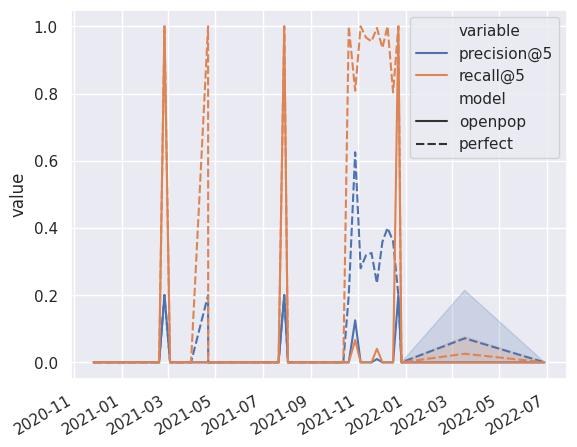

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-11-25 14:34:40,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,openpop
1,2020-11-25 14:34:40,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,openpop
2,2020-12-08 19:36:55,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,openpop
3,2020-12-14 23:33:20,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,openpop
4,2020-12-20 00:53:45,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2022-03-17 21:46:45,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,perfect
82,2022-03-17 21:46:45,1.0,1.0,0.357143,0.357143,1.0,1.0,0.714286,0.714286,0.933333,1.0,1.0,1.0,perfect
83,2022-06-28 08:19:45,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,perfect
84,2022-06-28 08:19:45,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,perfect


Cannot show ipywidgets in text

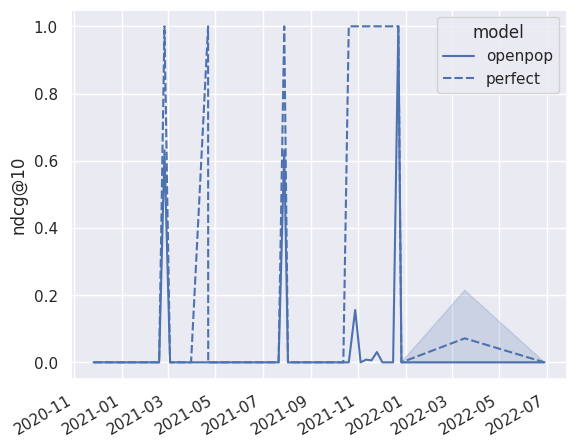

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,0.2,1.0,1.000000,1.000000,0.10,1.0,1.000000,1.000000,0.066667,1.0,1.000000,1.000000
6,0.6,1.0,0.513736,0.513736,0.55,1.0,0.527473,0.527473,0.533333,1.0,0.541209,0.541209
7,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,1.0,1.0,0.357143,0.357143,1.00,1.0,0.714286,0.714286,0.933333,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,0.057018,0.162791,0.149090,0.149090,0.037897,0.162791,0.154850,0.154850,0.030149,0.162791,0.158538,0.158538
std,0.156083,0.371340,0.346883,0.346883,0.127323,0.371340,0.354915,0.354915,0.112906,0.371340,0.362291,0.362291
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000


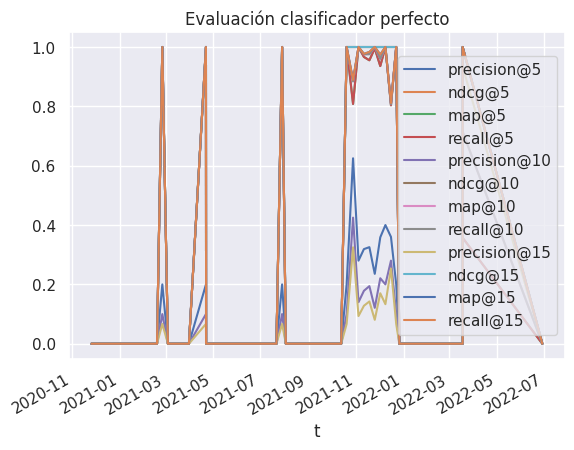

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 86 folds
From 2020-11-25 14:31:40 to 2022-07-26 17:09:25


,train,test,open,test users,test vpv,test vpp
count,86.000000,86.000000,86.000000,86.000000,20.000000,20.000000
mean,7421.186047,41.069767,46.686047,18.081395,0.695486,1.850833
std,8528.600235,172.145547,162.131846,80.236740,0.359623,1.753399
min,2.000000,0.000000,0.000000,0.000000,0.020833,0.021053
25%,85.250000,0.000000,1.250000,0.000000,0.450276,1.000000
50%,188.000000,0.000000,4.000000,0.000000,0.916667,1.125000
75%,17722.000000,0.000000,14.000000,0.000000,1.000000,2.125000
max,17737.000000,1166.000000,1292.000000,544.000000,1.000000,7.000000


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2020-11-26,2,0,2,0,NaN,NaN,NaT,NaT
1,2020-12-03,2,0,0,0,NaN,NaN,NaT,NaT
2,2020-12-10,15,6,6,5,0.833333,2.500000,2020-12-10 01:44:20,2020-12-10 21:18:45
3,2020-12-17,30,0,0,0,NaN,NaN,NaT,NaT
4,2020-12-24,34,0,0,0,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...
81,2022-06-16,17723,0,14,0,NaN,NaN,NaT,NaT
82,2022-06-23,17723,14,14,1,0.071429,0.071429,2022-06-28 08:12:30,2022-06-28 08:19:45
83,2022-06-30,17737,0,14,0,NaN,NaN,NaT,NaT
84,2022-07-07,17737,0,14,0,NaN,NaN,NaT,NaT


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 17 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window


            train  test  i
t                         
2020-11-26      2     0  0
2020-12-03      2     0  1
2020-12-10     15     6  2
2020-12-17     30     0  3
2020-12-24     34     0  4
2020-12-31     34     0  5
2021-01-07     34     0  6
2021-01-14     36     0  7
2021-01-21     36     0  8
2021-01-28     49     2  9


Cannot show ipywidgets in text

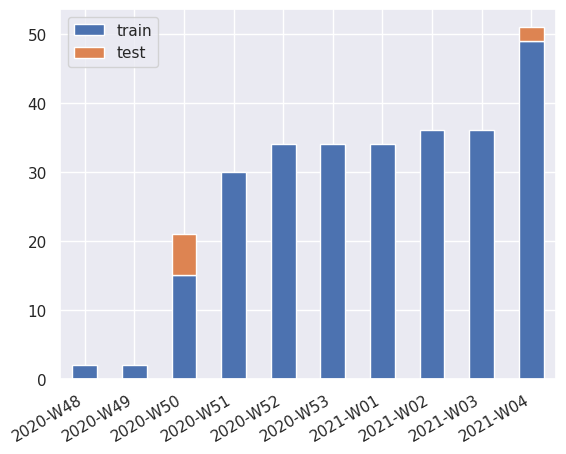

In [38]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

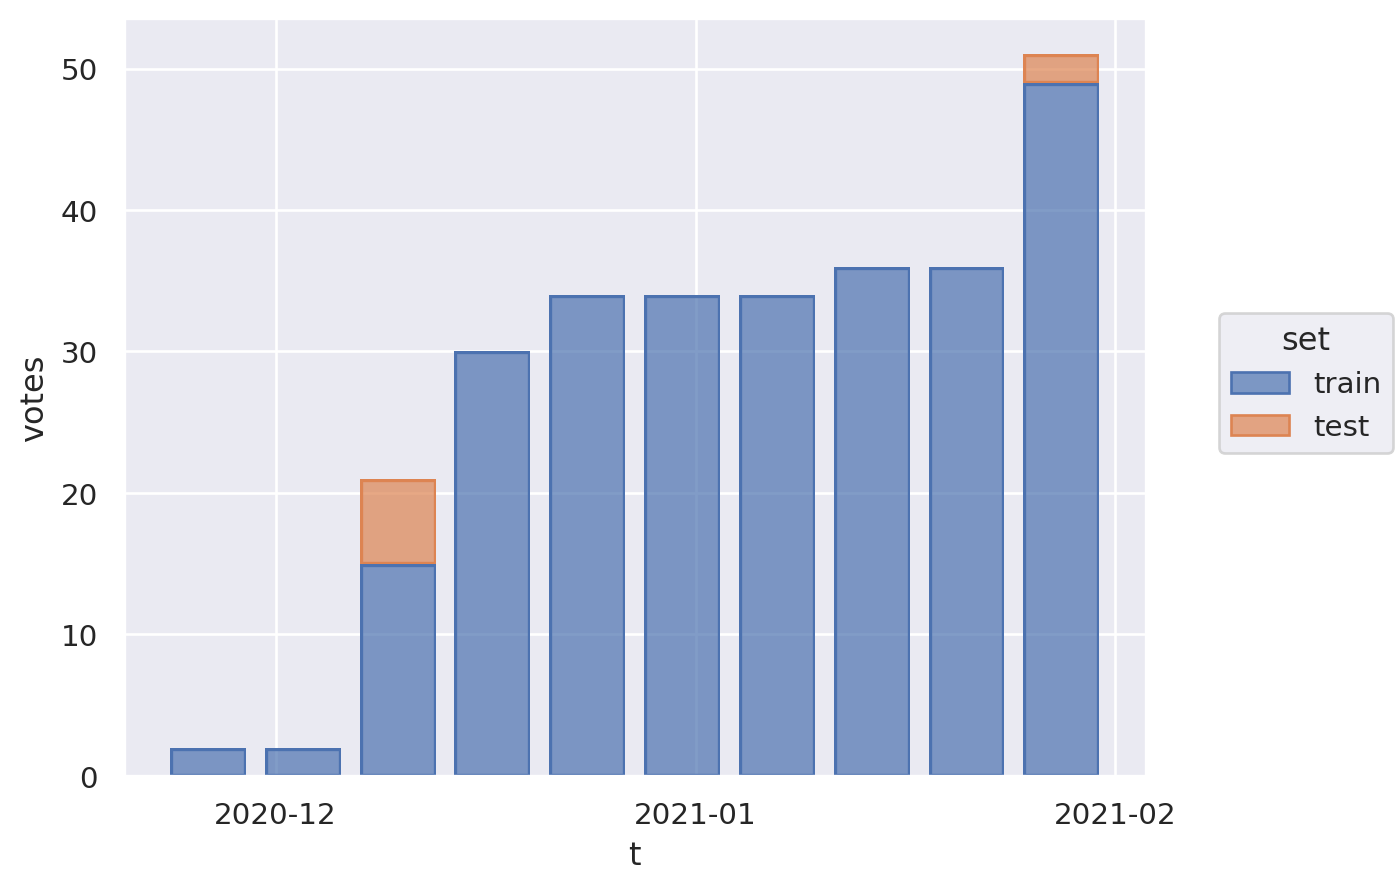

In [39]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())